<a href="https://colab.research.google.com/github/ghafoor545/100DaysOfBuildables/blob/main/task7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("camnugent/california-housing-prices")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'california-housing-prices' dataset.
Path to dataset files: /kaggle/input/california-housing-prices


📌 Step 1: Import Libraries

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [14]:
# Load dataset (cleaned from Task 5/6)
df = pd.read_csv("housing.csv")

# Create categorical features (like in Task 6)
df["income_cat"] = pd.cut(df["median_income"],
                          bins=[0, 2, 4, 6, np.inf],
                          labels=["Low", "Medium", "High", "Very High"])

df["age_cat"] = pd.cut(df["housing_median_age"],
                       bins=[0, 10, 20, 30, 40, 60],
                       labels=["0-10", "11-20", "21-30", "31-40", "40+"])


In [15]:
numeric_features = ["housing_median_age", "total_rooms", "total_bedrooms", "population", "median_income"]
categorical_features = ["income_cat", "age_cat"]
target = "median_house_value"

X = df[numeric_features + categorical_features]
y = df[target]

# Preprocessing (scaling 2 numeric + encoding categories)
numeric_transformer = StandardScaler()
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, ["total_rooms", "population"]),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ],
    remainder="passthrough"
)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [17]:
from sklearn.impute import SimpleImputer

models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42)
}

results = {}

# Preprocessing (scaling 2 numeric + encoding categories + imputing missing values)
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, ["housing_median_age", "total_rooms", "total_bedrooms", "population", "median_income"]),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ],
    remainder="passthrough"
)


for name, model in models.items():
    pipeline = Pipeline(steps=[("preprocessor", preprocessor),
                               ("model", model)])

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    results[name] = {"MAE": mae, "RMSE": rmse, "R2": r2}

                            MAE          RMSE        R2
Linear Regression  57765.784634  79387.887462  0.519048
Decision Tree      67575.562016  95900.091259  0.298171
Random Forest      50136.271698  70379.557356  0.622005


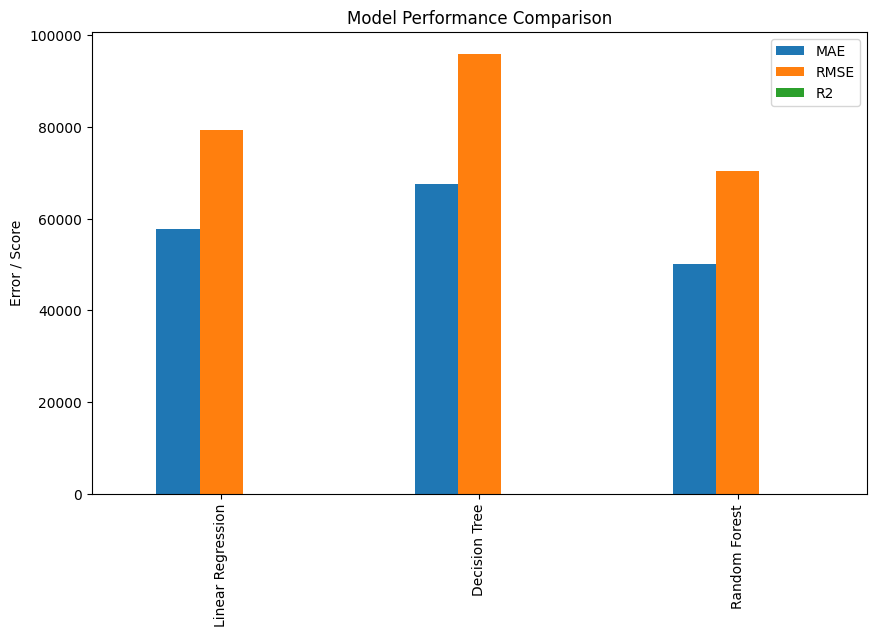

In [18]:
results_df = pd.DataFrame(results).T
print(results_df)

# Visualization: Bar chart of metrics
results_df.plot(kind="bar", figsize=(10,6))
plt.title("Model Performance Comparison")
plt.ylabel("Error / Score")
plt.show()


Best Model: Random Forest


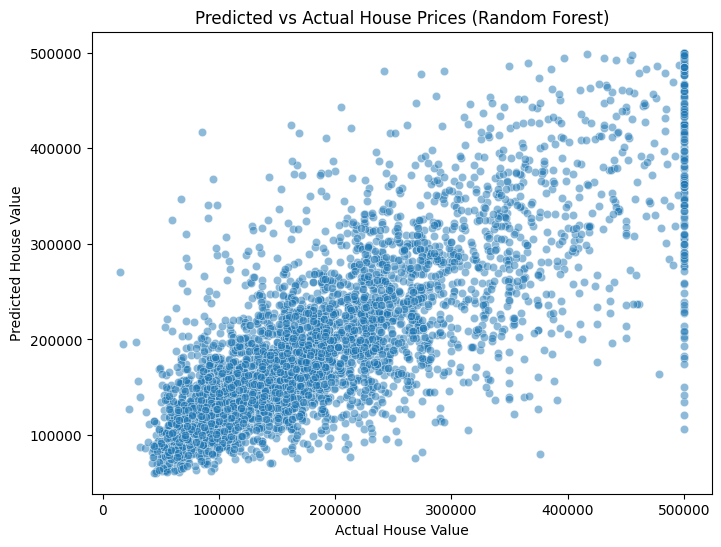

In [19]:
best_model_name = results_df["R2"].idxmax()
print("Best Model:", best_model_name)

# Refit best model for visualization
best_model = models[best_model_name]
pipeline = Pipeline(steps=[("preprocessor", preprocessor),
                           ("model", best_model)])
pipeline.fit(X_train, y_train)
y_pred_best = pipeline.predict(X_test)

plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred_best, alpha=0.5)
plt.xlabel("Actual House Value")
plt.ylabel("Predicted House Value")
plt.title(f"Predicted vs Actual House Prices ({best_model_name})")
plt.show()
